/home/es301lab/anaconda3/envs/ssd/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/es301lab/anaconda3/envs/ssd/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/es301lab/anaconda3/envs/ssd/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/es301lab/anaconda3/envs/ssd/lib/python3.7/s

/gpu:0   size= 0  Time: 1.0088863372802734
/cpu:0   size= 0  Time: 0.005357265472412109
----------------------------------------------------------------------------------------------------
/gpu:0   size= 500  Time: 0.005747795104980469
/cpu:0   size= 500  Time: 0.030074357986450195
----------------------------------------------------------------------------------------------------
/gpu:0   size= 1000  Time: 0.008397102355957031
/cpu:0   size= 1000  Time: 0.015113592147827148
----------------------------------------------------------------------------------------------------
/gpu:0   size= 1500  Time: 0.009969472885131836
/cpu:0   size= 1500  Time: 0.033072710037231445
----------------------------------------------------------------------------------------------------
/gpu:0   size= 2000  Time: 0.01417398452758789
/cpu:0   size= 2000  Time: 0.06484651565551758
----------------------------------------------------------------------------------------------------
/gpu:0   size= 2500  Time: 

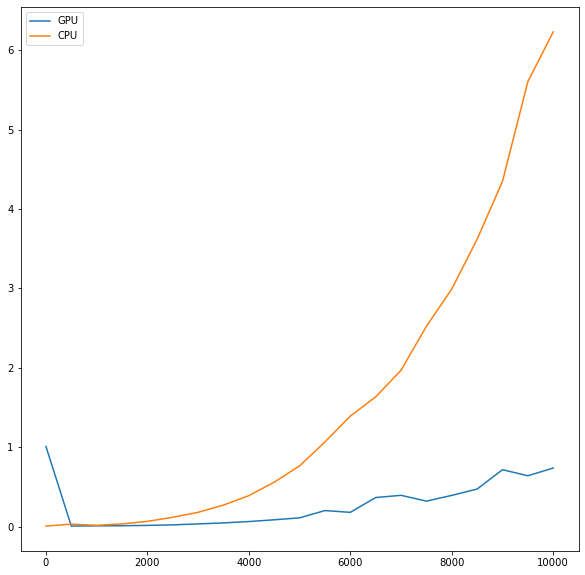

In [1]:
import tensorflow as tf
import time


#讓tensorflow自行動態分配記憶體空間而不是強制佔用所有空間導致Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 
sess = tf.Session(config=config)


def DeviceTest(device_name,size):
    with tf.device(device_name):       
        M1=tf.random_normal([size,size],name='M1')
        M2=tf.random_normal([size,size],name='M2')
        mul=tf.matmul(M1,M2,name='mul')
        sum_result=tf.reduce_sum(mul,name='sum_result')
        

        start_time=time.time()
        
        with tf.Session() as sess:
            result=sess.run(sum_result)
        
        take_time=time.time()-start_time       
        print(device_name,"  size=",size, " Time:",take_time)
        
        return take_time  #這樣append到SET才有東西


Gpu_Set=[];  Cpu_set=[];  Size_set=[]

for i in range(0,10001,500):
    TestGpu=DeviceTest("/gpu:0",i)
    TestCpu=DeviceTest("/cpu:0",i)
    
    print("-"*100)
    
    Gpu_Set.append(TestGpu)
    Cpu_set.append(TestCpu)
    Size_set.append(i)
    
    
    
    
import matplotlib.pyplot as plt
fig=plt.gcf()
fig.set_size_inches(10,10)

plt.plot(Size_set, Gpu_Set ,label='GPU')
plt.plot(Size_set, Cpu_set ,label='CPU')
plt.legend()

In [ ]:
# %load MNIST_train.py
#!/usr/bin/env python

# In[1]:


import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout,Dense,Flatten,Conv2D,AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,Softmax
import matplotlib.pyplot as plt
import numpy as np


# In[2]:
'''
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
'''


#將MNIST 手寫數字資料讀進來
mnist = tf.keras.datasets.mnist
# mnist 的load_data()會回傳已經先分割好的training data 和 testing data
# 並且將每個 pixel 的值從 Int 轉成 floating point 同時做normalize
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print('Loading finished')


#讓tensorflow自行動態分配記憶體空間而不是強制佔用所有空間導致Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True 
sess = tf.compat.v1.Session(config=config)

# In[3]:


x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))


# In[4]:


model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation='tanh', input_shape=(28,28,1)))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=16, kernel_size=(5,5),strides=(1,1), activation='tanh'))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=10, kernel_size=(3,3), strides=(1,1), padding='same',activation='tanh'))
model.add(Flatten())
model.add(Dense(units=120, activation='tanh'))
model.add(Dense(units=84, activation='tanh'))
model.add(Dense(units=10, activation='softmax'))


# model每層定義好後需要經過compile
opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# In[5]:


# 訓練網路模型
history = model.fit(x_train, y_train, 
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
# 儲存h5權重檔
model.save('MNIST_ep10.h5')


# In[6]:


# 查看參數
model.summary()


# In[7]:


# 畫圖觀察Accuracy與Loss
print(history.history.keys())
f = open('history_key_1.txt', 'w')
#x = str(history.history.keys())
#print(x)
f.write(str(history.history.keys())) 
f.close()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig('[Accuracy]20200805_MNIST_ep10_b128.jpg')
plt.show()
# summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left') 
plt.savefig('[Loss]20200805_MNIST_ep10_b128.jpg')
plt.show()


# In[8]:


# 使用前面讀取的test資料來驗證模型的準確度
# Load the model.
model = load_model('MNIST_ep10.h5')

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)

# Output the result
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# In[ ]:






In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
print(tf.test.is_built_with_cuda())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5883276460310773386
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7144866284351791928
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435266048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3247848740146413463
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13991750992352884684
physical_device_desc: "device: XLA_GPU device"
]
True


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']